# 🌃 🌇 🏙 Аугментация изображений с преобразованием координат ключевых точек лица
* В этом ноутбуке на примере нескольких изображений продемонстрирован способ аугментации с соответсвующими преобразованиями координат ключевых точек лица.
* Будем использовать библиотеку [Albumentations](https://albumentations.ai/), в которой уже есть преобразования для ключевых точек ([смотреть тут](https://albumentations.ai/docs/getting_started/keypoints_augmentation/)).


### 1️⃣ Смотрим на исходные изображения (до применения аугментаций)

Импортируем необходимые библиотеки и зададим требуемые константы:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torchvision import transforms
import os
import copy

# Библиотека для аугментации картинок
import albumentations as A 

PATH_DATA = "/kaggle/input/vkcv2022-contest-01-facial-landmarks/contest01_data/"
PATH_TRAIN = os.path.join(PATH_DATA, "train")
PATH_TRAIN_IMAGE = os.path.join(PATH_TRAIN, "images")
PATH_TRAIN_LANDMARK = os.path.join(PATH_TRAIN, "landmarks.csv")

Функция, для отрисовки изображения и цветных ключевых точек:

In [2]:
def draw_landmarks(img, landmarks):
    """
    Рисует цветные ключевые точки на лице.
    landmarks: np.array.
    """
    image = np.copy(img) # чтобы исходное изображение не менялось
    for i, point in enumerate(landmarks):
        if 0 <= i and i < 273:    # ОВАЛ ЛИЦА
            color = (0, 0, 255)
        elif 273 <= i and i < 401: # БРОВИ
            color = (128, 0, 0)
        elif 401 <= i and i < 587: # НОС
            color = (255, 255, 0)
        elif 587 <= i and i < 841: # ГЛАЗА
            color = (0, 255, 255)
        elif 841 <= i and i < 969: # РОТ
            color = (255, 0, 0)
        elif 969 <= i < 971: # ЗРАЧКИ
            color = (0, 0, 0)
        x, y = point.astype(np.int32)
        cv2.circle(img=image, center=(x, y), radius=1, color=color, thickness=-1)
    return image

Задаём пути до изображений, которые будем визуализировать:

In [3]:
dwayne_johnson_img_path = "/kaggle/input/vkcv2022-contest-01-facial-landmarks/contest01_data/train/images/acf8a79eb7f4c7709c8b9b22ad7dcf91.jpg"
fifty_cent_img_path = "/kaggle/input/vkcv2022-contest-01-facial-landmarks/contest01_data/train/images/83b604d583d5b01e2f102f86598017ba.jpg"
robert_de_niro_img_path = "/kaggle/input/vkcv2022-contest-01-facial-landmarks/contest01_data/train/images/3ce64cc92545b9c33424f2ef65bb86f0.jpg"
james_franco_img_path = "/kaggle/input/vkcv2022-contest-01-facial-landmarks/contest01_data/train/images/b0748b70cd104dcd65f0ac378214cf85.jpg"
alla_pugacheva_img_path  = "/kaggle/input/vkcv2022-contest-01-facial-landmarks/contest01_data/train/images/be7751607fec67570ea892e1c48de642.jpg"
andrey_arshavin_img_path = "/kaggle/input/vkcv2022-contest-01-facial-landmarks/contest01_data/train/images/1b41c68d084922d281cb5e1ee6a65c59.jpg"
brad_pitt_img_path3 = "/kaggle/input/vkcv2022-contest-01-facial-landmarks/contest01_data/train/images/d5a277caf04a277113cbdf6590bb1f6f.jpg"
zendaya_img_path = "/kaggle/input/vkcv2022-contest-01-facial-landmarks/contest01_data/train/images/910ec52a981b5fd07577501e8bc7a040.jpg"


train_images_for_visualization_path = set([
    dwayne_johnson_img_path,
    fifty_cent_img_path,
    robert_de_niro_img_path,
    james_franco_img_path,
    alla_pugacheva_img_path,
    andrey_arshavin_img_path,
    brad_pitt_img_path3,
    zendaya_img_path,
])

Находим `img` и `landmarks` экземпляров по заданным путям:

In [4]:
train_samples_for_visualization = []
img_paths = []
img_landmarks = []

with open(PATH_TRAIN_LANDMARK, "rt") as fp:
    for i, line in enumerate(fp):
        if i == 0:
            continue  # skip header
        
        elements = line.strip().split("\t")
        image_name = os.path.join(PATH_TRAIN_IMAGE, elements[0])
        
        if image_name in train_images_for_visualization_path:
            
            img_paths.append(image_name)
            
            landmarks = list(map(np.int32, elements[1:]))
            landmarks = np.array(landmarks, dtype=np.int32).reshape((len(landmarks) // 2, 2))
            
            img_landmarks.append(landmarks)

img_landmarks = torch.as_tensor(img_landmarks)

for i, img_name in enumerate(img_paths):
    sample = {}
    
    image = cv2.imread(img_name)                   # читаем изображение
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # перевод в другое цветовое пространство
    
    sample["image"] = image
    sample["landmarks"] = img_landmarks[i]
    
    train_samples_for_visualization.append(sample)

Рисуем исходные изображения:

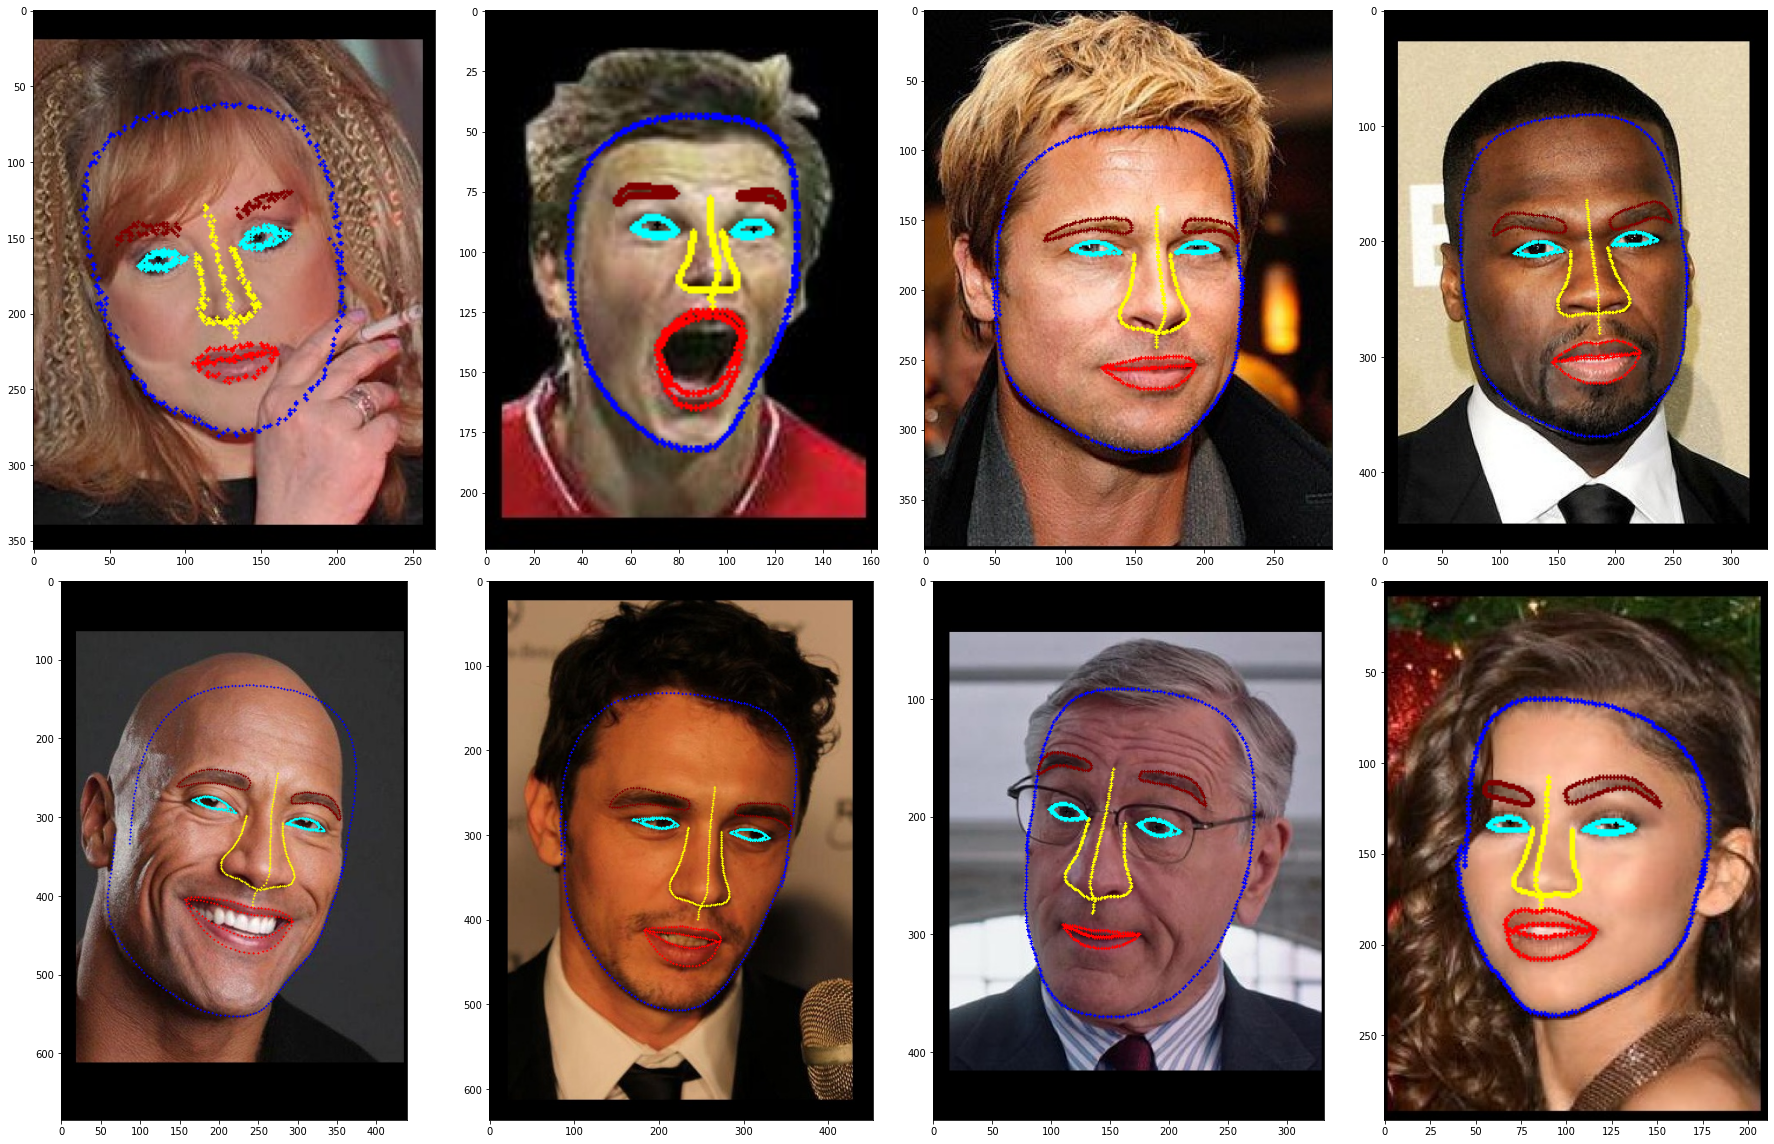

In [5]:
NUM_COLS = 4
NUM_ROWS = 2

plt.figure(figsize=(25, NUM_ROWS * 8))

for i in range(len(train_samples_for_visualization)):
    sample = copy.deepcopy(train_samples_for_visualization[i])
    img_tmp = draw_landmarks(sample["image"], np.array(sample["landmarks"]))
    plt.subplot(NUM_ROWS, NUM_COLS, i + 1)
    plt.imshow(img_tmp)

plt.tight_layout() # отступы между соседними рисунками
plt.show()

Надеюсь, что Вы всех узнали 😊

### 2️⃣ Задаём аугментации
* Стоит заметить, что некоторые аугментации меняют координаты ключевых точек (геометрические преобразования изображения), а некоторые нет.
* Я специально укажу большую вероятность аугментаций, чтобы Вы смогли увидеть их все сразу при визуализации.

Задаём аугментации, которые меняют координаты ключевых точек:
* Обратите внимание на специльный параметр `keypoint_params`

In [6]:
augmentations1 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate([-25, 25], p=0.5),
],  keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

Задаём аугментации, которые не меняют координаты ключевых точек:

In [7]:
augmentations2 = A.Compose([
    A.GaussNoise(p=0.5, var_limit=(10.0, 30.0)),
    A.RandomBrightnessContrast(p=0.5),
    # Чёрные прямоугольники - имитация посторонних предметов.
    A.CoarseDropout(p=0.5, min_holes=4, max_holes=10, min_width=20, max_width=50, min_height=20, max_height=50), 
    A.ToGray(p=0.3), 
])

### 3️⃣ Смотрим на аугментированные изображения:

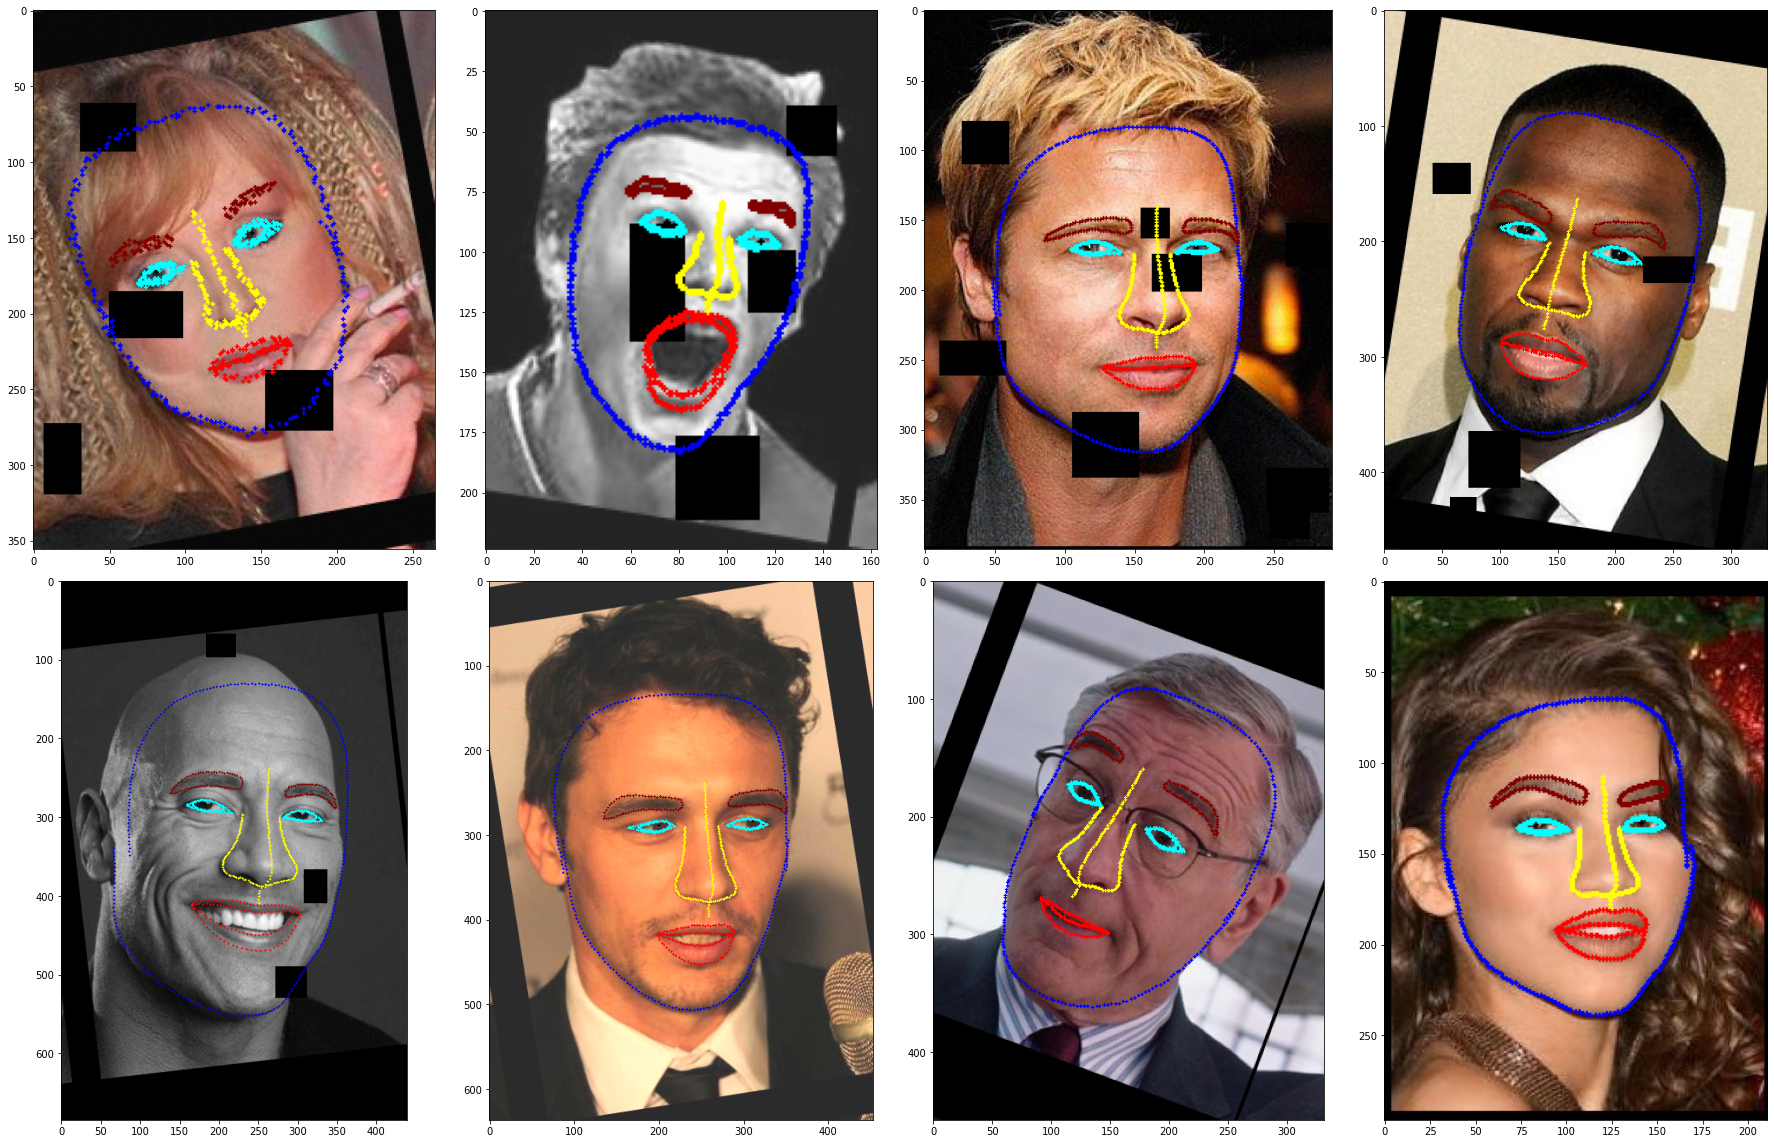

In [10]:
NUM_COLS = 4
NUM_ROWS = 2

plt.figure(figsize=(25, NUM_ROWS * 8))

for i in range(len(train_samples_for_visualization)):
    sample = copy.deepcopy(train_samples_for_visualization[i])
    
    # Применение аугментаций, которые меняют координаты ключевых точек.
    transformed = augmentations1(image=np.array(sample['image']), keypoints=np.array(sample["landmarks"]).reshape(-1, 2))
    sample['image'], sample["landmarks"] = transformed['image'], torch.Tensor(transformed['keypoints'])
    
    # Применение аугментаций, которые не меняют координаты ключевых точек.
    transformed = augmentations2(image=np.array(sample['image']))
    sample['image'] = transformed['image']
    
    # Рисуем.
    img_tmp = draw_landmarks(sample["image"], np.array(sample["landmarks"]).reshape(-1, 2))
    plt.subplot(NUM_ROWS, NUM_COLS, i + 1)
    plt.imshow(img_tmp)

plt.tight_layout() # отступы между соседними рисунками
plt.show()

#### Обратите внимание, что в результате аугментаций все ключевые точки изменили координаты требуемым образом. Мы достигли своей цели! 🎉